In [4]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.5 MB/s 


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
from scipy import fftpack as fp
from scipy import linalg

from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

0.008 --> 0.006 --> 0.004 --> 0.004 --> 0.004 --> 0.003 --> 0.003 --> 0.003 --> 0.003 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 0.002 --> 


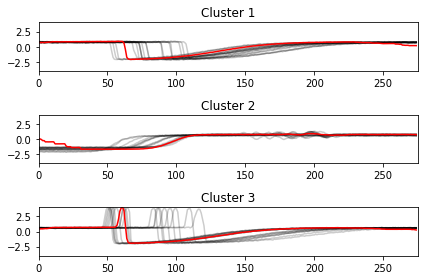

In [111]:
seed = 0
np.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes and 50 first time series
X_train = X_train[y_train < 4]
X_train = X_train[:50]
np.random.shuffle(X_train)
# For this method to operate properly, prior scaling is required
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
sz = X_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [112]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
X_train = X_train.reshape(50, 275)
#X_train = pd.DataFrame(X_train)
X_train.shape

(50, 275)

In [178]:
# fuzzy c-meansの定義
def fcm(X, C, THETA, max_iter):
    plt.figure(figsize=(16, 12))
    n, m = X.shape
    # メンバシップ値の初期化
    u = np.random.rand(C, n)
    u /= u.sum(axis=0)

    step = 0
    # for step in range(5):
    while step < max_iter:
        step += 1
        # u^θを先に計算しておく
        u_theta = u**THETA
        # クラスタ中心の計算
        b = u_theta @ X / u_theta.sum(1)[:, np.newaxis]
        # メンバシップ行列の更新
        d = dist.cdist(b, X)

        u = d**(-2/(THETA-1.0))
        u /= u.sum(axis=0)

        vpc = (u**2).sum() / n

        # 目的関数の計算
        obj = ((u**THETA) * d**2).sum()

        if abs(obj_prev - obj) < 1e-5:
            break
        else:
            obj_prev = obj

    for yi in range(C):
        plt.subplot(C, 1, 1 + yi)
        for xx in range(n):
            plt.plot(X_train[xx], "k-", alpha=u[yi, xx])
        plt.plot(b[yi], "r-")
        plt.xlim(0, b.shape[1])
        plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    return u, b, d, step, vpc, obj


# fuzzy c-shape+の定義
def fcs_plus(X, C, THETA, max_iter):
    plt.figure(figsize=(16, 12))
    n, m = X.shape
    # メンバシップ値の初期化
    u = np.random.rand(C, n)
    u /= u.sum(axis=0)

    step = 0
    obj_prev = np.inf
    # for step in range(5):
    while step < max_iter:
        step += 1
        # u^θを先に計算しておく
        u_theta = u**THETA
        # クラスタ中心の計算
        b = u_theta @ X / u_theta.sum(1)[:, np.newaxis]
        # メンバシップ行列の更新
        #d = dist.cdist(b, X)
        d = np.array([[get_SBD(b[j], X[i]) for i in range(n)] for j in range(C)])

        u = d**(-2/(THETA-1.0))
        u /= u.sum(axis=0)

        vpc = (u**2).sum() / n

        # 目的関数の計算
        obj = ((u**THETA) * d**2).sum()

        if abs(obj_prev - obj) < 1e-5:
            break
        else:
            obj_prev = obj

    for yi in range(C):
        plt.subplot(C, 1, 1 + yi)
        for xx in range(n):
            plt.plot(X_train[xx], "k-", alpha=u[yi, xx])
        plt.plot(b[yi], "r-")
        plt.xlim(0, b.shape[1])
        plt.ylim(-4, 4)
        plt.title("Cluster %d" % (yi + 1))

    return u, b, d, step, vpc, obj


# Function for getting a shape-based distance (SBD)
def get_SBD(x, y):

    # Define FFT-size based on the length of input
    p = int(x.shape[0])
    FFTlen = int(2**np.ceil(np.log2(2*p-1)))

    # Compute the normalized cross-correlation function (NCC)
    CC = fp.ifft(fp.fft(x, FFTlen)*fp.fft(y, FFTlen).conjugate()).real

    # Reorder the IFFT result
    CC = np.concatenate((CC[-(p-1):], CC[:p]), axis=0)

    # To avoid zero division
    denom = linalg.norm(x) * linalg.norm(y)
    if denom < 1e-10:
        denom = np.inf
    NCC = CC / denom

    # Search for the argument to maximize NCC
    ndx = np.argmax(NCC, axis=0)
    dist = 1 - NCC[ndx]

    return dist

((3, 50), (3, 275), (3, 50), (50, 275))

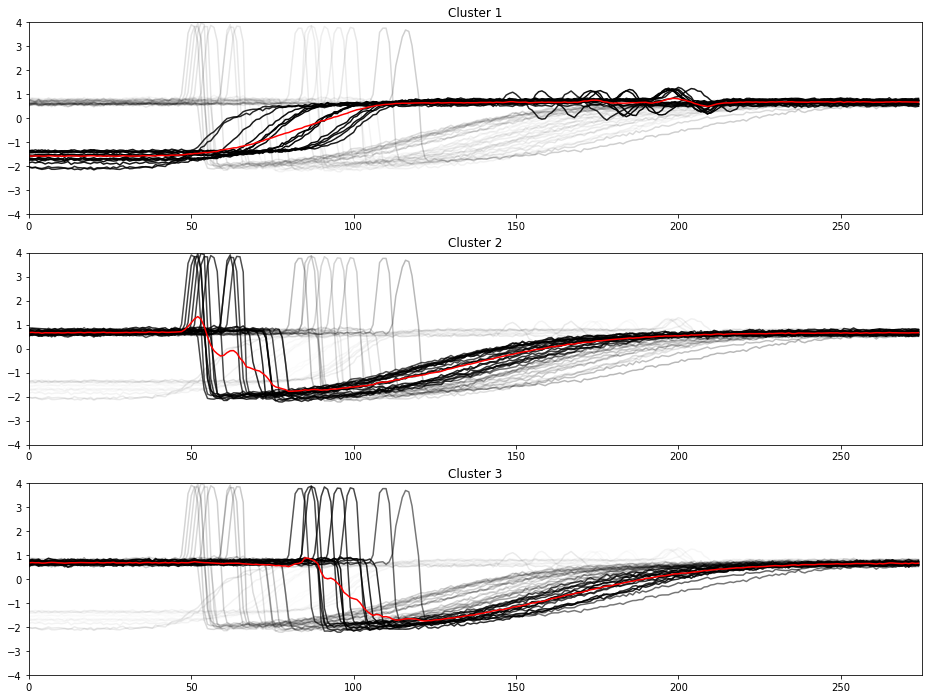

In [147]:
u, b, d = fcm(X_train, C=3, THETA=2, max_iter=200)
u.shape, b.shape, d.shape, X_train.shape

2 46 0.5939108328593121 0.18782166571862424 1.4931037242300522
3 25 0.6045966937292157 0.4068950405938234 0.26546100636759784
4 22 0.5842604225008843 0.44568056333451245 0.1316050277800943
5 26 0.5954776808347252 0.4943471010434065 0.10159601403829642
6 28 0.5694562351798383 0.48334748221580603 0.08930358671200404
7 45 0.5871672268146336 0.5183617646170725 0.04865865810215067
8 22 0.5632073895235732 0.5008084451697979 0.03923405917086414
9 21 0.5094978303847673 0.4481850591828631 0.06974833281702847


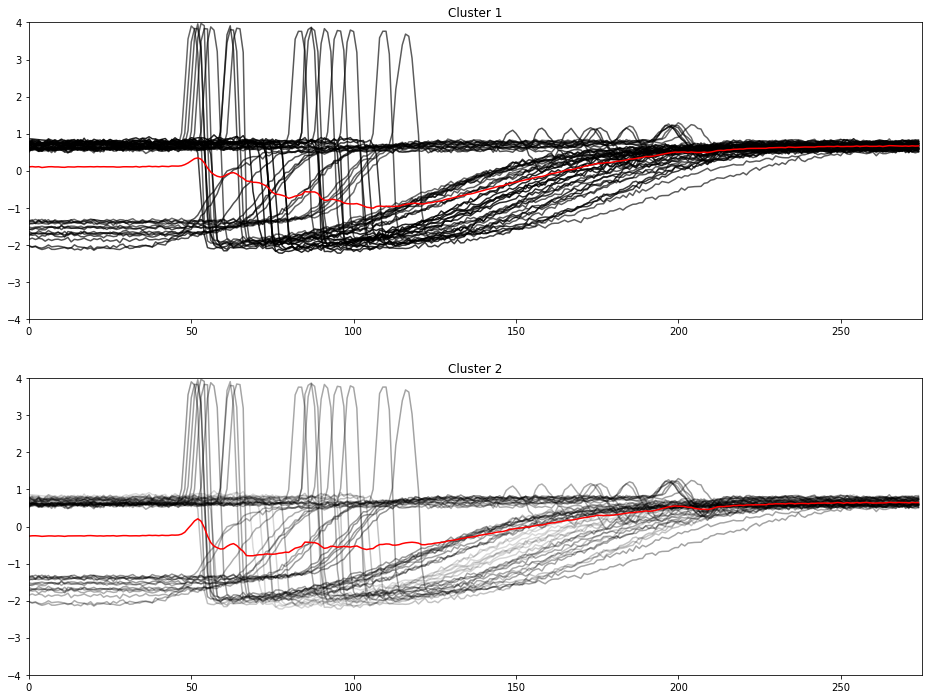

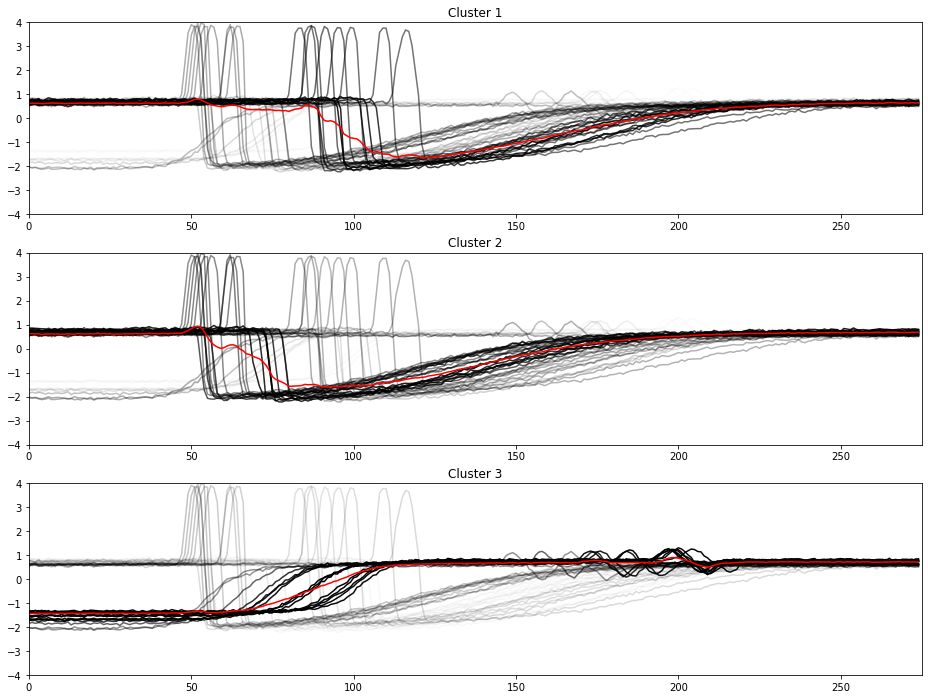

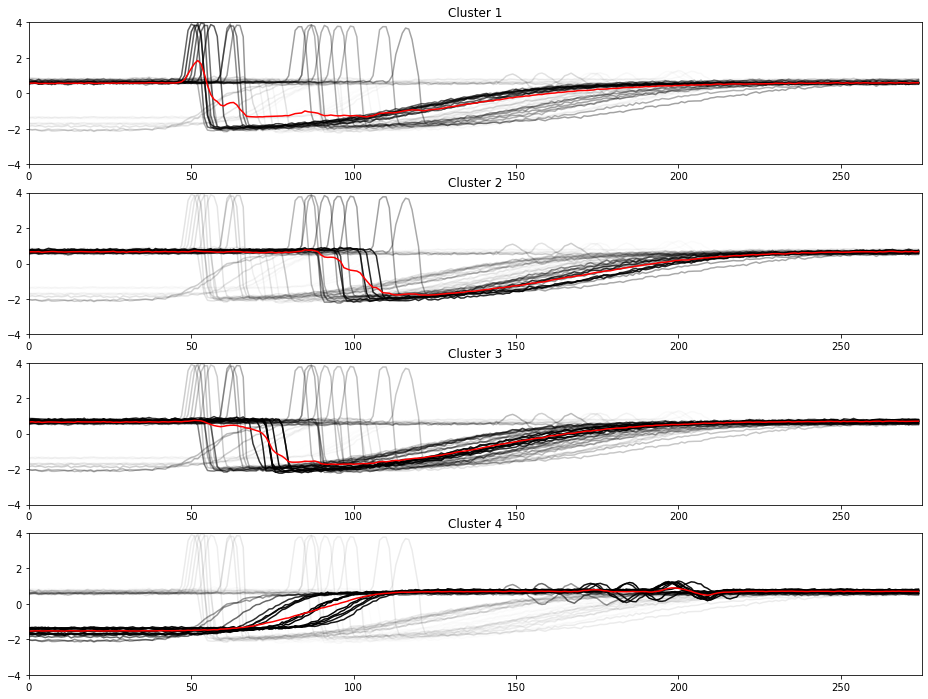

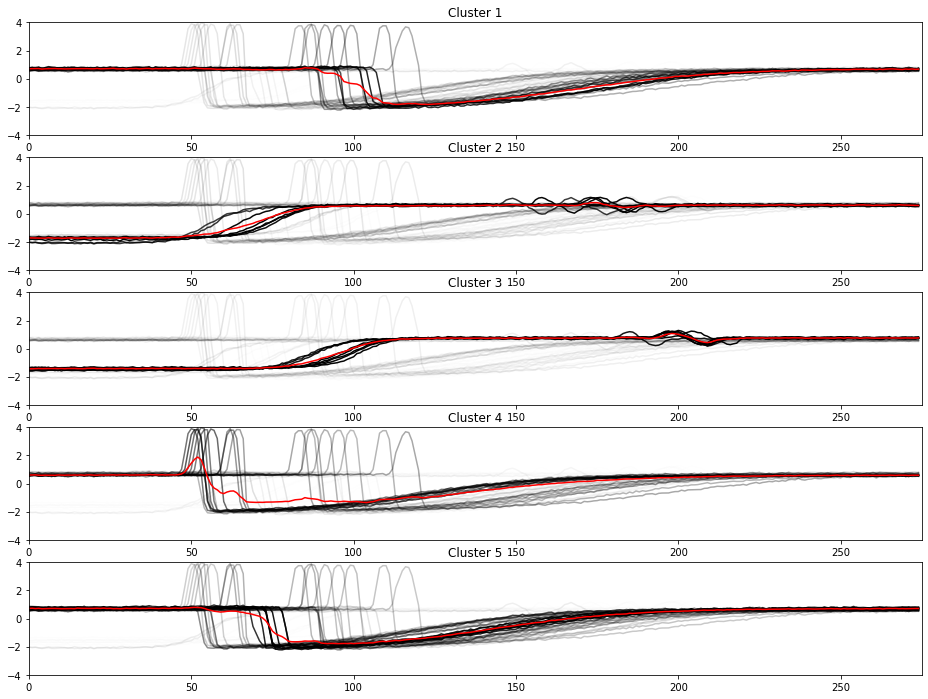

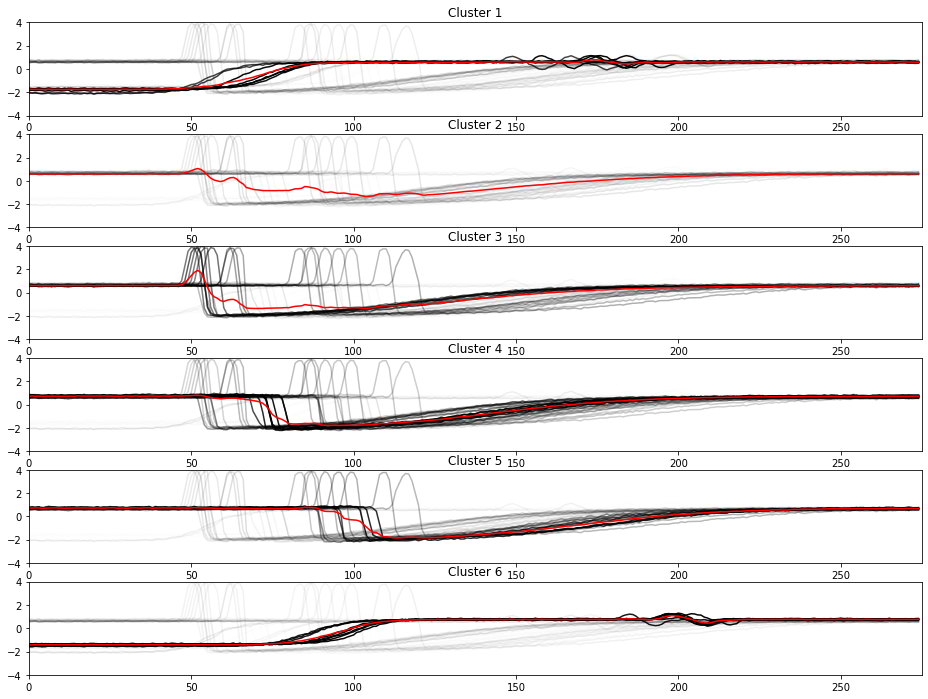

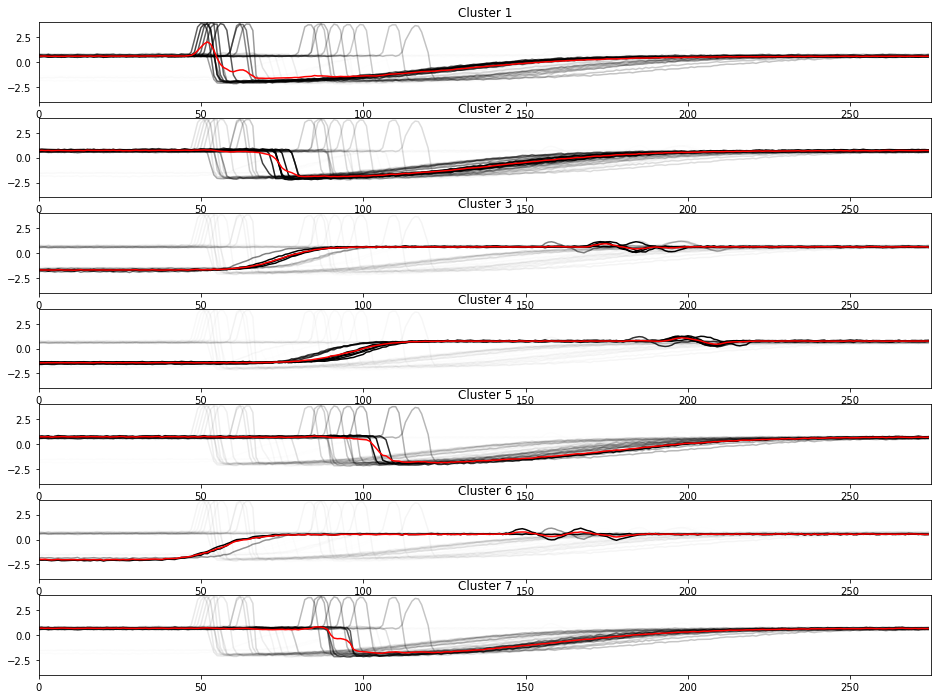

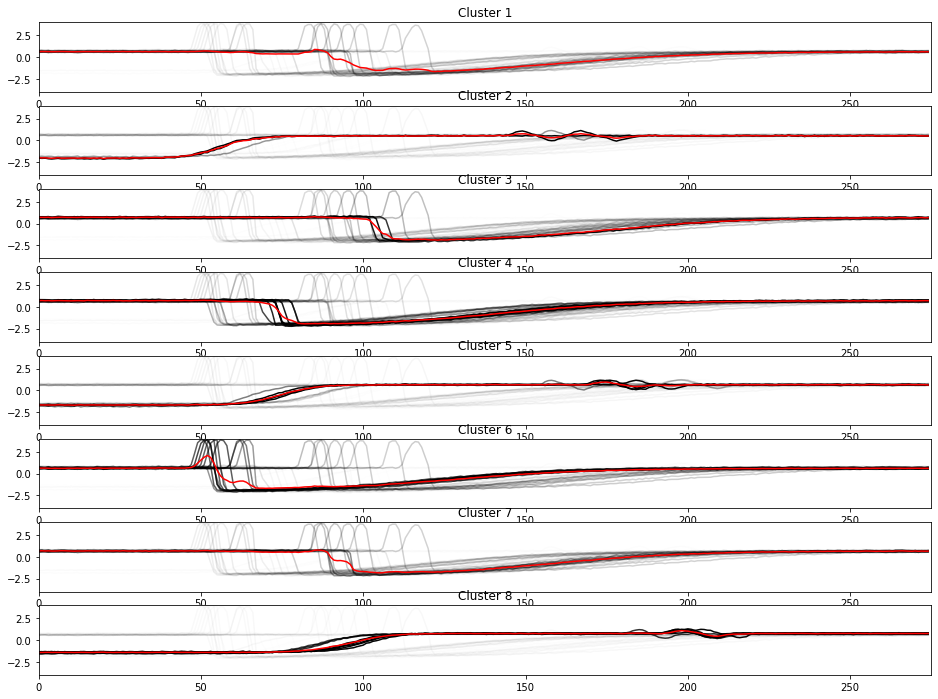

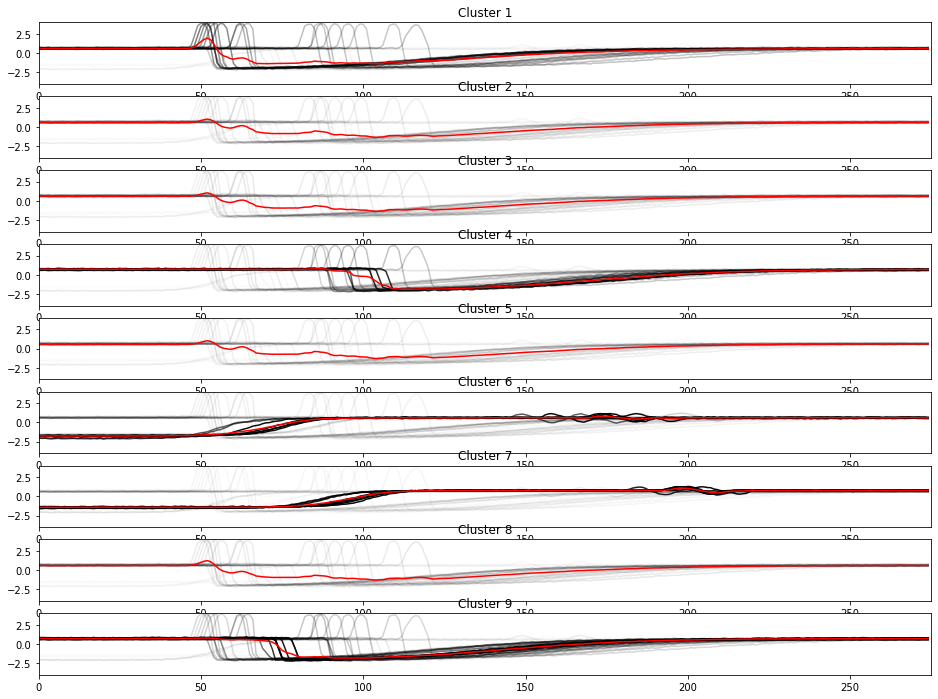

In [182]:
distortions = []
for c in range(2, 10):
    u, b, d, s, vpc, sse = fcs_plus(X_train, C=c, THETA=2, max_iter=100)
    vmpc = 1 - c/(c-1)*(1-vpc)
    distortions.append(sse)
    print(c, s, vpc, vmpc, sse)

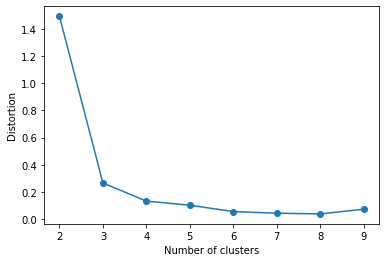

In [181]:
plt.plot(range(2, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

((4, 50), (4, 275), (4, 50), 34, 0.5842617229923889)

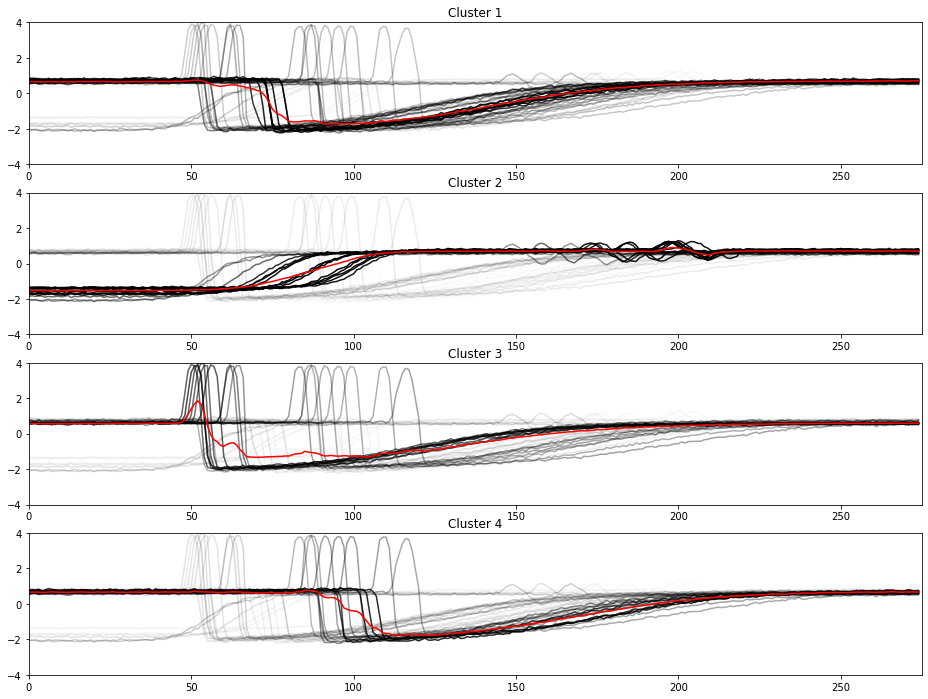

In [173]:
u, b, d, s, vpc, sse = fcs_plus(X_train, C=4, THETA=2, max_iter=100)
u.shape, b.shape, d.shape, s, vpc

In [67]:
pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.717657,0.115707,0.078973,0.029110,0.024341,0.017761,0.040412,0.221898,0.148477,0.154179,...,0.172896,0.171080,0.182008,0.910168,0.696106,0.012579,0.211932,0.148732,0.233811,0.753535
1,0.211682,0.797410,0.079509,0.047432,0.027489,0.020994,0.068429,0.727096,0.744321,0.742964,...,0.778605,0.697577,0.730965,0.069178,0.249641,0.017794,0.690413,0.750291,0.709324,0.181393
2,0.070661,0.086883,0.841518,0.923458,0.948170,0.961246,0.891159,0.051006,0.107201,0.102857,...,0.048500,0.131343,0.087027,0.020654,0.054253,0.969627,0.097655,0.100977,0.056865,0.065072


In [68]:
pd.DataFrame(b)

,0,1,2,3,4,5,6,7,8,9,...,265,266,267,268,269,270,271,272,273,274
0,0.668248,0.680529,0.670721,0.674857,0.656671,0.660847,0.678704,0.687874,0.681880,0.670787,...,0.663092,0.662956,0.650148,0.642329,0.636514,0.653011,0.634016,0.663341,0.645020,0.652213
1,0.668850,0.678999,0.665126,0.670538,0.642906,0.664717,0.659734,0.663007,0.656131,0.666630,...,0.674008,0.662043,0.664243,0.657840,0.658124,0.656541,0.653524,0.662302,0.660023,0.665707
2,-1.571142,-1.569784,-1.566913,-1.562395,-1.574614,-1.573367,-1.558132,-1.564803,-1.572279,-1.569128,...,0.683362,0.693203,0.683786,0.699060,0.686024,0.688774,0.686056,0.679960,0.680961,0.678578


In [93]:
X_train[0]

array([ 0.50346668,  0.59984199,  0.60508153,  0.5457536 ,  0.64661708,
        0.60821723,  0.58521539,  0.62749229,  0.55765525,  0.5532272 ,
        0.5746662 ,  0.59018443,  0.48227814,  0.55930826,  0.59315984,
        0.62910523,  0.59043488,  0.59576458,  0.55785562,  0.63039758,
        0.57266255,  0.59930101,  0.6044103 ,  0.61169355,  0.58081739,
        0.59465255,  0.53217891,  0.53449312,  0.60784655,  0.52459512,
        0.65366991,  0.60082378,  0.56969716,  0.57266255,  0.58658788,
        0.58769991,  0.62004875,  0.59281922,  0.51823354,  0.55502046,
        0.558066  ,  0.61529009,  0.54963066,  0.56734288,  0.56658149,
        0.63605787,  0.58479462,  0.54909969,  0.56572994,  0.55591208,
        0.59221813,  0.61458882,  0.56754324,  0.58933288,  0.63545678,
        0.62836388,  0.56734288,  0.59180738,  0.61317625,  0.60431012,
        0.55164432,  0.62053964,  0.63204056,  0.54704596,  0.60735566,
        0.61555057,  0.66763531,  0.59316986,  0.56617074,  0.57

In [83]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,265,266,267,268,269,270,271,272,273,274
0,0.503467,0.599842,0.605082,0.545754,0.646617,0.608217,0.585215,0.627492,0.557655,0.553227,...,0.562264,0.555121,0.544652,0.567012,0.614729,0.600603,0.485013,0.574145,0.590735,0.550793
1,0.717015,0.743092,0.660783,0.781492,0.601655,0.735198,0.715242,0.700545,0.707588,0.697389,...,0.703961,0.681400,0.683394,0.682452,0.670831,0.667625,0.693712,0.703761,0.606694,0.692510
2,-2.029798,-2.052840,-2.032503,-2.074179,-2.087603,-2.055144,-2.002748,-2.054142,-2.042321,-2.033605,...,0.568214,0.549931,0.488209,0.602266,0.560821,0.561612,0.506071,0.551634,0.540213,0.517612
3,-1.349254,-1.326412,-1.425793,-1.323006,-1.409463,-1.373097,-1.386522,-1.372697,-1.392432,-1.360675,...,0.739616,0.747781,0.751327,0.796820,0.779178,0.801168,0.755846,0.777956,0.787784,0.716023
4,-1.708112,-1.742274,-1.728850,-1.804989,-1.745681,-1.763613,-1.694688,-1.690580,-1.764715,-1.778040,...,0.650464,0.641858,0.627131,0.617333,0.618005,0.657717,0.597076,0.602737,0.657356,0.583321
5,-1.746781,-1.704504,-1.682464,-1.708511,-1.695989,-1.697591,-1.730251,-1.689978,-1.703101,-1.663529,...,0.641386,0.686518,0.698931,0.682431,0.643180,0.632821,0.630867,0.629575,0.622833,0.629655
6,-1.361978,-1.346850,-1.312888,-1.347952,-1.311486,-1.365684,-1.319901,-1.404355,-1.323207,-1.366085,...,0.859403,0.757798,0.768508,0.775560,0.804653,0.819500,0.808350,0.819090,0.768037,0.805144
7,0.774379,0.817217,0.785419,0.758260,0.742771,0.795137,0.774800,0.785088,0.818990,0.764521,...,0.785289,0.774890,0.785579,0.785159,0.833316,0.801488,0.830882,0.784026,0.793934,0.801248
8,0.611633,0.622392,0.695525,0.547816,0.580887,0.577881,0.625107,0.550952,0.590123,0.633603,...,0.620138,0.621671,0.592628,0.594291,0.638151,0.559387,0.594361,0.605652,0.638011,0.623304
9,0.647169,0.581148,0.617184,0.611824,0.619729,0.613858,0.565079,0.621692,0.538921,0.637251,...,0.577051,0.614078,0.537278,0.633153,0.647239,0.661745,0.613327,0.585206,0.649032,0.594002
